In [1]:
import pygame as pg
import sys
import random
from PIL import ImageGrab
import cv2
from collections import deque 
import os
import matplotlib.pyplot as plt
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import keyboard as k
position = 10, 10
os.environ['SDL_VIDEO_WINDOW_POS'] = str(position[0]) + "," + str(position[1])
rgb_weights = [0.2989, 0.5870, 0.1140]
debug_frame=[]

pygame 2.0.0 (SDL 2.0.12, python 3.6.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


KeyboardInterrupt: 

In [ ]:
class Network(nn.Module):
    def __init__(self,lr,input_dims,actions,l1_dim,l2_dim):
        super(Network,self).__init__()
        self.lr=lr
        self.input_dims=input_dims
        self.actions=actions
        self.l1_dim=l1_dim
        self.l2_dim=l2_dim
        self.l1=nn.Conv2d(1,32,kernel_size=8,stride=2)
        self.l2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.l3=nn.Conv2d(32,64,kernel_size=4,stride=2)
        self.l4=nn.MaxPool2d(kernel_size=2,stride=2)
        self.l5=nn.Conv2d(64,64,kernel_size=3,stride=1)
        self.l6=nn.MaxPool2d(kernel_size=2,stride=2)
        self.l7=nn.Linear(64,256)
        self.l8=nn.Linear(256,self.actions)
        self.optimizer=optim.Adam(self.parameters(),lr=self.lr)
        self.device=T.device('cuda:0' if T.cuda.is_available() else 'cpu:0')
        self.to(self.device)
        
    def forward(self,observation):
        state=T.Tensor(observation).to(self.device)
        x=F.relu(self.l1(state))
        x=F.relu(self.l2(x))

        x=F.relu(self.l3(x))
        x=F.relu(self.l4(x))
        x=F.relu(self.l5(x))
        x=F.relu(self.l6(x))
        x=T.flatten(x)
        x=F.relu(self.l7(x))
        x=self.l8(x)
#         print(x.s
#         x=self.l3(x)
        
        return x

In [ ]:
class Agent():
    def __init__(self,alpha,beta,input_dims,actions,l1_dim,l2_dim,gamma):
        self.gamma=gamma
        self.log_probs=None
        self.actor=Network(alpha,input_dims,actions,l1_dim,l2_dim)
        self.critic=Network(beta,input_dims,1,l1_dim,l2_dim)
    
    def act(self,observation):
        probs=F.softmax(self.actor.forward(observation))
        action_probs=T.distributions.Categorical(probs)
        action=action_probs.sample()
        self.log_probs=action_probs.log_prob(action)
        
        return action.item()
    
    def learn(self,state,reward,new_state,done):
        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()
        
        q_val_state=self.critic.forward(state)
        q_val_new_state=self.critic.forward(new_state)
        
        delta=((reward+self.gamma*q_val_new_state*(1-int(done)))-q_val_state)
        
        actor_loss=-self.log_probs*delta
        critic_loss=delta**2
        
        (actor_loss+critic_loss).backward()
        
        self.actor.optimizer.step()
        self.critic.optimizer.step()   

In [ ]:
# ag=Agent(0.000025,0.000025,6720,2,32,32,0.995)
# t=T.ones([1,1,80,80])
# x=ag.actor.forward(t)
# print(x)

In [ ]:
def draw_floor():
    screen.blit(floor,(floor_y,450))
    screen.blit(floor,(floor_y+288,450))
    
def draw_bird():
    screen.blit(bird,bird_rect)

def grab_frame():
    
    img = ImageGrab.grab(bbox=(15,15,360,600)) #bbox specifies specific region (bbox= x,y,width,height *starts top-left)
    img_np = np.array(img) #this is the array obtained from conversion
#         frame = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
    grayscale_image = np.dot(img_np[...,:3], rgb_weights)/255
    grayscale_image=cv2.resize(grayscale_image,(80,80),interpolation=cv2.INTER_AREA)
    grayscale_image=T.from_numpy(grayscale_image)
    grayscale_image=T.unsqueeze(grayscale_image,0)
    frame_l.append(grayscale_image)
    debug_frame.append(grayscale_image)
        
def grab_nxt_frame():
    img = ImageGrab.grab(bbox=(15,15,360,600)) #bbox specifies specific region (bbox= x,y,width,height *starts top-left)
    img_np = np.array(img) #this is the array obtained from conversion
#         frame = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
    grayscale_image = np.dot(img_np[...,:3], rgb_weights)/255
    grayscale_image=cv2.resize(grayscale_image,(80,80),interpolation=cv2.INTER_AREA)
    grayscale_image=T.from_numpy(grayscale_image)
    grayscale_image=T.unsqueeze(grayscale_image,0)
    nxt_frame_l.append(grayscale_image) 
#         print(img_np)
        
def create_pipe():
    pipe_h=random.choice(pipe_height)
    bottom_pipe=pipe.get_rect(midtop=(300,pipe_h))
    top_pipe=pipe.get_rect(midbottom=(300,pipe_h-120))
    return bottom_pipe,top_pipe

def move_pipes(pipes):
    for pipe in pipes:
        pipe.centerx-=2
    return pipes

def draw_pipes(pipes):
    for p in pipes:
        if p.bottom>=512:
            screen.blit(pipe,p)
        else:
            flip_pipe=pg.transform.flip(pipe,False,True)
            screen.blit(flip_pipe,p)
            
def collision(pipes):
    for p in pipes:
        if bird_rect.colliderect(p):
            return True
    return False

def diff():
    x=None
    y=None
    if len(frame_l)==2:
        x=frame_l[1]
        y=frame_l[0]
        frame_l.clear()
        return x-y
def diff2():
    w=None
    z=None
    if len(nxt_frame_l)==2:
        w=nxt_frame_l[1]
        z=nxt_frame_l[0]
        nxt_frame_l.clear()
        return w-z
    

In [ ]:
agent=Agent(0.000025,0.000025,6720,2,32,32,0.995)

In [ ]:
score_history=[]
PATH_A='Actor_weights/'
PATH_C='Critic_weights/'

In [ ]:
for i in range(100000):
    pg.init()
    score=-1
    screen_height=512
    screen_width=288
    stop=0
    gravity=0.05
    screen=pg.display.set_mode((screen_width,screen_height))
    clock=pg.time.Clock()
    bg=pg.image.load('assets/background-day.png').convert()

    floor=pg.image.load('assets/base.png').convert()
    floor=pg.transform.scale(floor,(288,80))

    bird=pg.image.load('assets/bluebird-downflap.png').convert()
    bird_rect=bird.get_rect(center=(44,256))

    pipe=pg.image.load('assets/pipe-green.png').convert()
    pipe_list=deque(maxlen=5)
    SPAWNPIPE=pg.USEREVENT
    pg.time.set_timer(SPAWNPIPE,1500)
    pipe_height=[256,280,300,320,400]
    frame_count=0
    frame_l=[]
    nxt_frame_l=[]
    nxt_frame_count=0
    img=None
    reward=None
    img_diff=None
    floor_y=0
    action_taken=False
    val=False
    bird_mov=0
    state=None
    nxt_state=None
    while True:
        action=0
        if val==True:
            pg.quit()
            break
        if floor_y<=-288:
            floor_y=0
            
        if frame_count%15==0 and frame_count!=0:
            grab_frame()
            if len(frame_l)==2:
                state=diff()
                state=T.unsqueeze(state,0)
                state=state.float()
#                 print("state:",state.shape)
                action=agent.act(state)
                if action == 1:
                    k.press('space')
                

        for event in pg.event.get():
            if event.type == pg.QUIT:
                pg.quit()
                stop=1
    #             sys.exit()
            if event.type == pg.KEYDOWN:
                if event.key == pg.K_SPACE:
                    bird_mov=0
                    bird_mov-=2.5
            if event.type == SPAWNPIPE:
                pipe_list.extend(create_pipe())
                score+=1

        if stop==1:
            break
        screen.blit(bg,(0,0))
        draw_bird()
        draw_pipes(pipe_list)
        draw_floor()

        floor_y-=1
        bird_rect.centery+=bird_mov
        if bird_rect.centery>=450:
            pg.quit()
            break
        elif bird_rect.centery<=0:
            bird_rect.centery=0
            
        bird_mov+=gravity

        pipe_list=move_pipes(pipe_list)

        val=collision(pipe_list)

        pg.display.update()
        clock.tick(120)
        
        reward=1 if val==False else -25000
        
        frame_count+=1
        if nxt_frame_count%15==0 and nxt_frame_count!=0:
            grab_nxt_frame()
            if len(nxt_frame_l)==2:              
                nxt_state=diff2()
                nxt_state=T.unsqueeze(nxt_state,0)
                nxt_state=nxt_state.float()
#                 print(nxt_state.shape)
                agent.learn(state,reward,nxt_state,val)
        nxt_frame_count+=1
    score_history.append(score)
    if i%1000==0:
        PATH_A=PATH_A+"iteration "+str(i)+"score: " + str(score)
        PATH_C=PATH_C+"iteration "+str(i)+"score: " + str(score)
        T.save(agent.actor.state_dict(), PATH_A)
        T.save(agent.critic.state_dict(), PATH_C)
        PATH_A='Actor_weights/'
        PATH_C='Critic_weights/'
#     print(score)

In [21]:
 debug_frame

[tensor([[[0.6283, 0.5956, 0.5998,  ..., 0.6932, 0.6795, 0.6307],
          [0.6191, 0.6121, 0.6004,  ..., 0.6819, 0.6819, 0.6721],
          [0.6147, 0.6158, 0.6146,  ..., 0.6819, 0.6819, 0.6796],
          ...,
          [0.5865, 0.5261, 0.5378,  ..., 0.5822, 0.5418, 0.5685],
          [0.5153, 0.5343, 0.5534,  ..., 0.5316, 0.5461, 0.5751],
          [0.7405, 0.7157, 0.7170,  ..., 0.7317, 0.7317, 0.7317]]],
        dtype=torch.float64),
 tensor([[[0.6237, 0.6237, 0.6237,  ..., 0.6237, 0.6237, 0.6237],
          [0.6237, 0.6237, 0.6237,  ..., 0.6237, 0.6237, 0.6237],
          [0.6237, 0.6237, 0.6237,  ..., 0.6237, 0.6237, 0.6237],
          ...,
          [0.7653, 0.7692, 0.7178,  ..., 0.7245, 0.7697, 0.7602],
          [0.6654, 0.5966, 0.5715,  ..., 0.7006, 0.6241, 0.5805],
          [0.7090, 0.7090, 0.7090,  ..., 0.7090, 0.7090, 0.7090]]],
        dtype=torch.float64),
 tensor([[[0.6237, 0.6237, 0.6237,  ..., 0.6237, 0.6237, 0.6237],
          [0.6237, 0.6237, 0.6237,  ..., 0.6237,

In [54]:
f=debug_frame[7]

In [55]:
f=f.numpy()

In [56]:
f

array([[[0.62371063, 0.62371063, 0.62371062, ..., 0.62371062,
         0.62371063, 0.62371063],
        [0.62371063, 0.62371063, 0.62371062, ..., 0.62371062,
         0.62371063, 0.62371063],
        [0.62371063, 0.62371063, 0.62371062, ..., 0.62371062,
         0.62371063, 0.62371063],
        ...,
        [0.76455903, 0.76882341, 0.71885926, ..., 0.72339836,
         0.77065854, 0.75985534],
        [0.66659315, 0.59630055, 0.57095913, ..., 0.69910133,
         0.62276342, 0.58055804],
        [0.70766665, 0.70766665, 0.70766665, ..., 0.70766665,
         0.70766665, 0.70766665]]])

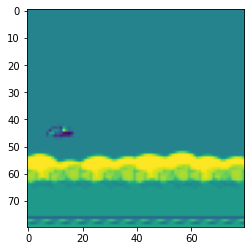

In [57]:
f=np.squeeze(f)
plt.imshow(f)

NameError: name 'score_history' is not defined